# Teoría de los Circuitos II - R4001  #
# Tarea Semanal 8 - Fiasche Nahuel #

# Parte 1 - Diseño de Filtros
A continuación se adjunta la consigna provista por la cátedra.

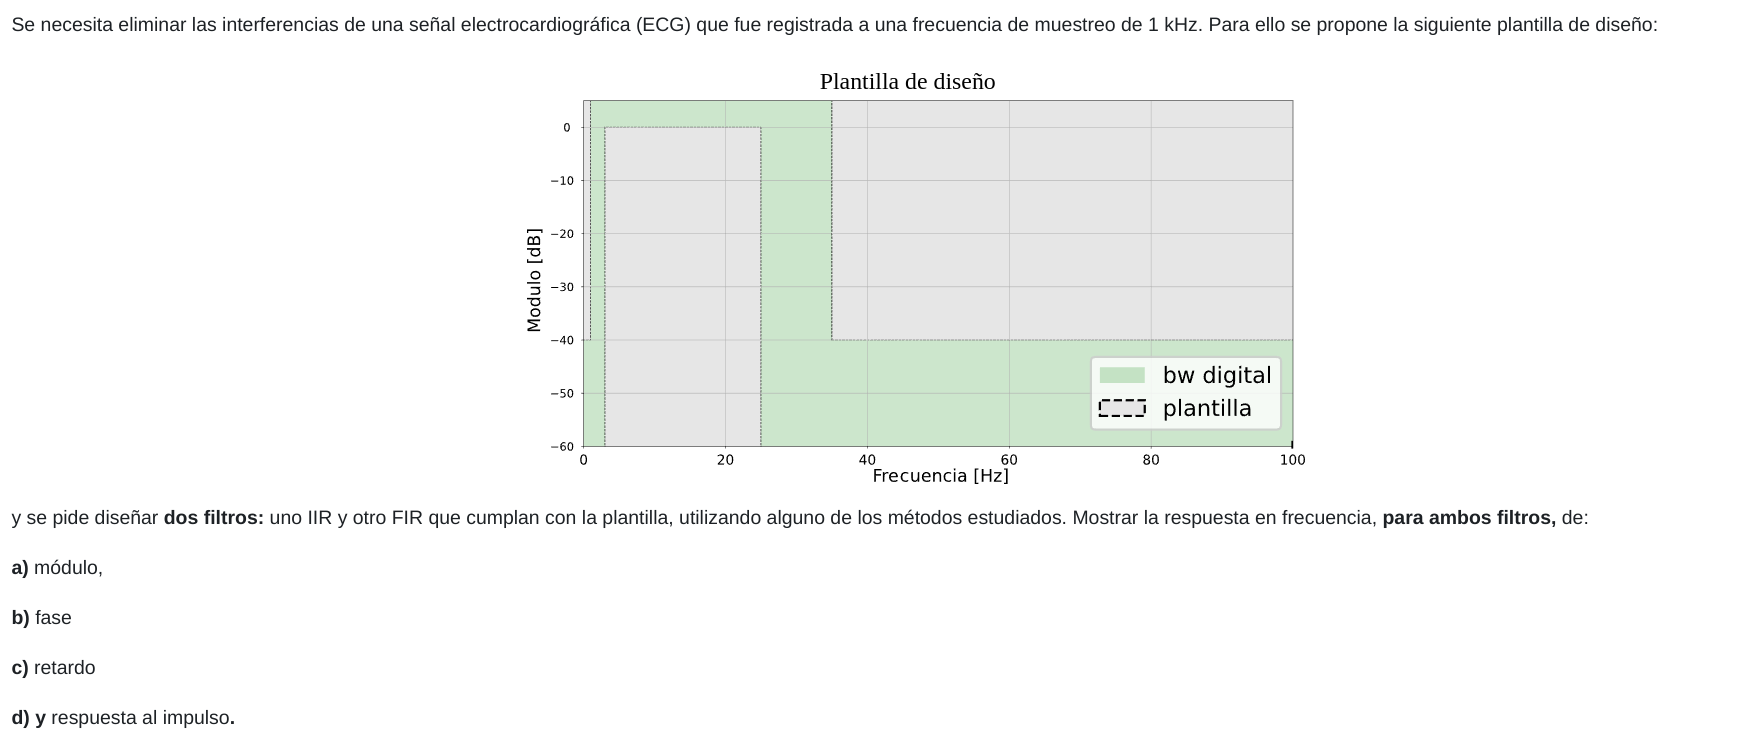

## Diseño del Filtro IIR

In [21]:
# Inicialización e importación de módulos

# Módulos para Jupyter
import warnings
warnings.filterwarnings('ignore')

# Módulos importantantes
import scipy.signal as sig
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio
from pytc2.sistemas_lineales import plot_plantilla

fs = 1000 # Hz
nyq_frec = fs / 2

# Plantilla del FIR
ripple = 0.1 # dB
atenuacion = 40 # dB

ws1 = 1.0 #Hz
wp1 = 3.0 #Hz
wp2 = 25.0 #Hz
ws2 = 35.0 #Hz

frecs = np.array([0.0,         ws1,         wp1,     wp2,     ws2,         nyq_frec   ]) / nyq_frec
gains = np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, -atenuacion])
gains = 10**(gains/20)

# Cálculo de los coeficientes
system=sig.iirdesign(wp=[wp1, wp2], ws=[ws1, ws2], gpass=ripple, gstop=atenuacion, analog=False, ftype='butter', output='sos', fs=1000)

Utilizando la directiva "print(system.shape)", se obtiene la cantidad de SOS que comforman al filtro.

In [22]:
print(system.shape)

(17, 6)


Del resultado se destaca que el filtro está compuesto por 17 secciones de Orden 2, es decir, que es un filtro IIR de orden 34.
A continuación, se adjuntan las simulaciones del filtro IIR.

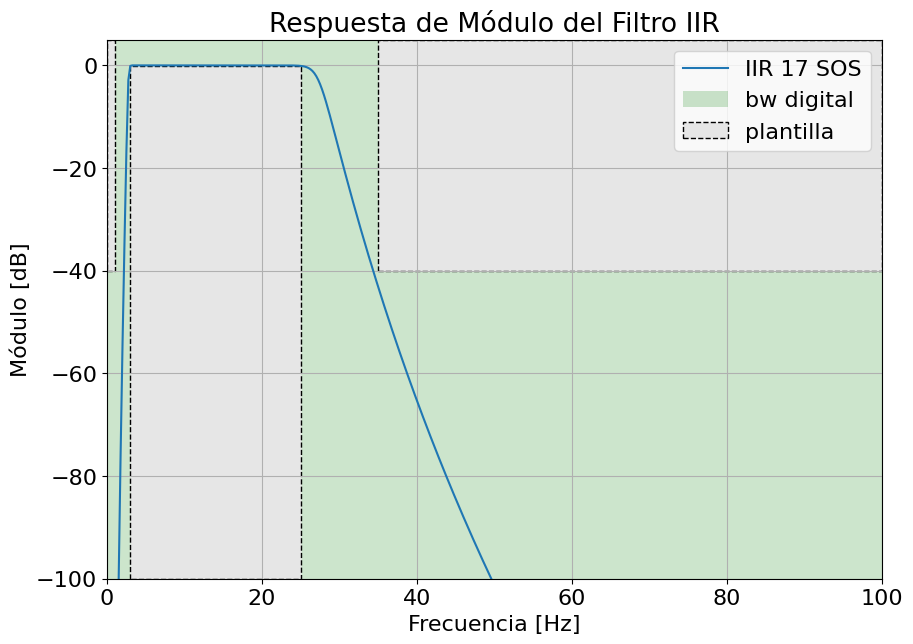

In [23]:
w, h=sig.sosfreqz(system, worN=2000, fs=fs)
## Respuesta de Módulo
plt.plot(w, 20 * np.log10(abs(h)), label='IIR {:d} SOS'.format(system.shape[0]))

plt.title('Respuesta de Módulo del Filtro IIR')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0, 100, -100, 5 ])

plot_plantilla(filter_type = 'bandpass', fpass = [3,25], ripple = ripple , fstop = [1,35], attenuation = atenuacion, fs = fs)


(0.0, 100.0, -6.283185307179586, 6.283185307179586)

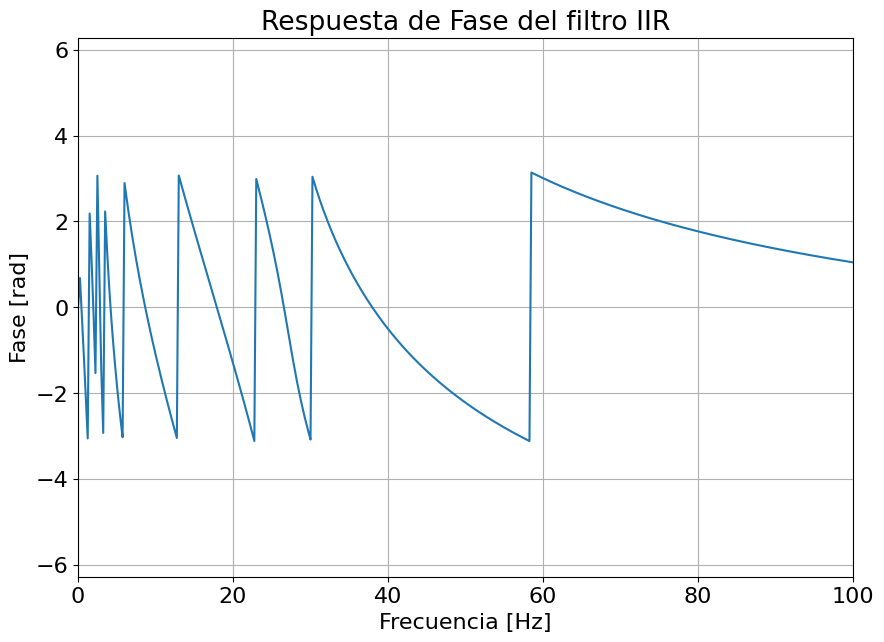

In [24]:

##Respuesta de Fase
phase=np.angle(h)
plt.plot(w, phase)

plt.title('Respuesta de Fase del filtro IIR')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Fase [rad]')
plt.grid()
plt.axis([0, 100, -2*np.pi, 2*np.pi ])

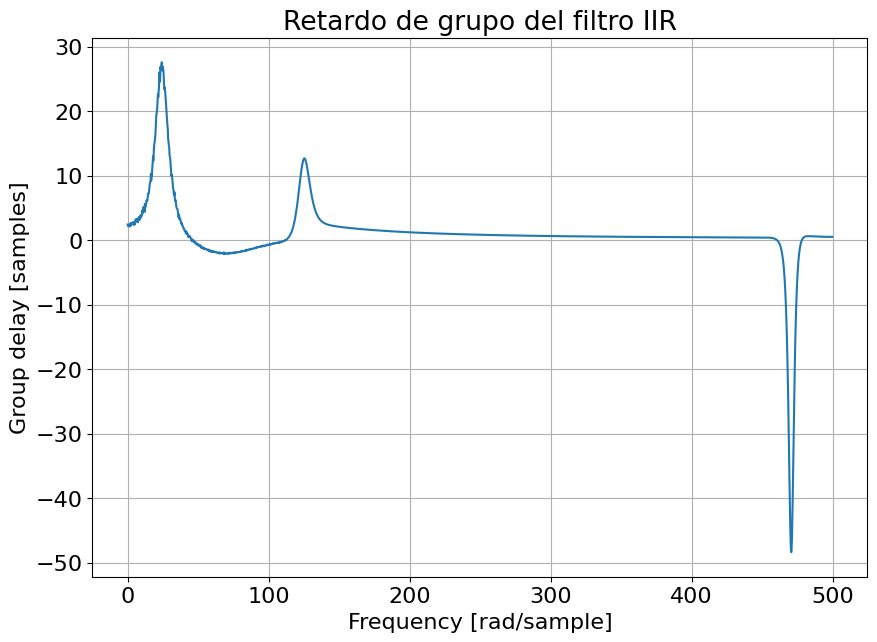

In [25]:

b,a = sig.sos2tf(system)
w, gd = sig.group_delay((b, a), w=2000, whole=False, fs=fs)

## Retardo de Grupo
plt.title('Retardo de grupo del filtro IIR')
plt.plot(w, gd)
plt.ylabel('Group delay [samples]')
plt.xlabel('Frequency [rad/sample]')
plt.grid()

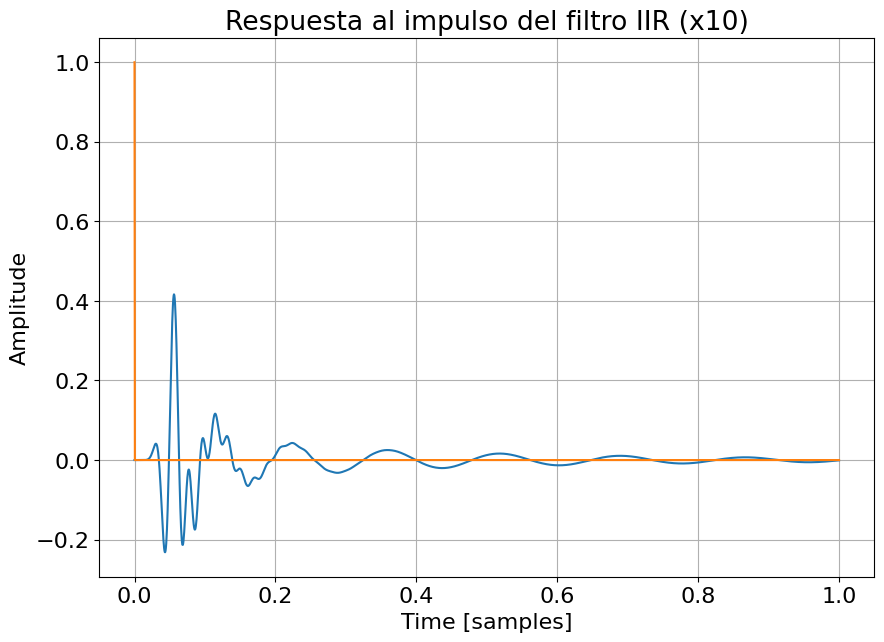

In [26]:

## Respuesta al Impulso
imp = sig.unit_impulse(2000)
response = sig.sosfilt(system, imp)

plt.plot(np.linspace(0,1, 2000), response*10)
plt.plot(np.linspace(0,1, 2000), imp)
#plt.xlim([0,0.2])

plt.xlabel('Time [samples]')
plt.ylabel('Amplitude')
plt.title('Respuesta al impulso del filtro IIR (x10)')

plt.grid(True)
plt.show()

## Diseño del Filtro FIR

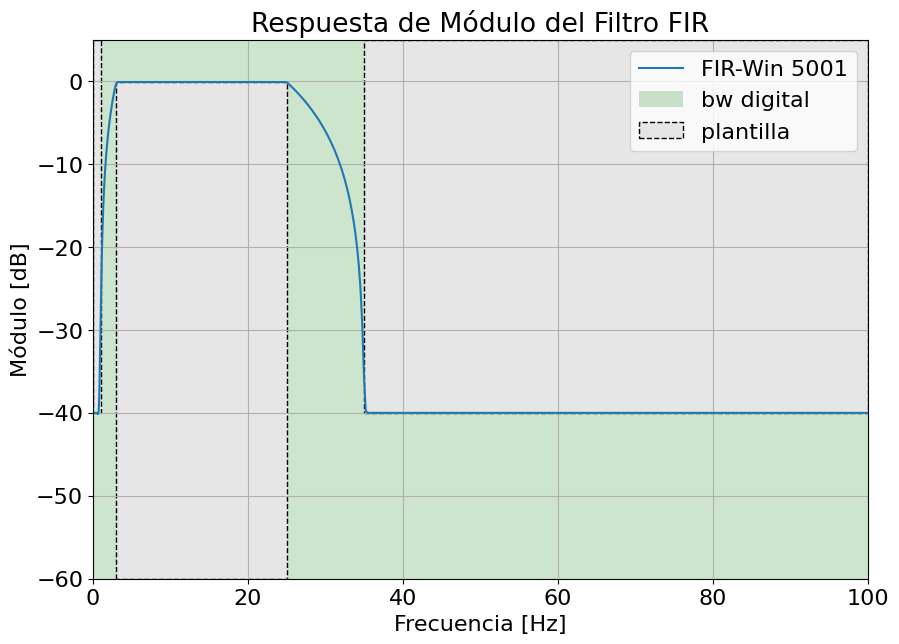

In [27]:
  
cant_coeficientes = 5001

num_win1 = sig.firwin2(cant_coeficientes, frecs, gains , window='hamming' )

den = 1.0

# muestreo el filtro donde me interesa verlo según la plantilla.
w  = np.append(np.logspace(-1, 0.8, 250), np.logspace(0.9, 1.6, 250) )
w  = np.append(w, np.linspace(110, nyq_frec, 100, endpoint=True) ) / nyq_frec * np.pi

_,hh_win1 = sig.freqz(num_win1, den, w)

# renormalizo el eje de frecuencia
w = w / np.pi * nyq_frec

plt.plot(w, 20 * np.log10(abs(hh_win1)), label='FIR-Win {:d}'.format(num_win1.shape[0]))

plt.title('Respuesta de Módulo del Filtro FIR')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0, 100, -60, 5 ]);

axes_hdl = plt.gca()
axes_hdl.legend()

plot_plantilla(filter_type = 'bandpass', fpass = [3,25], ripple = ripple , fstop = [1,35], attenuation = atenuacion, fs = fs)

(0.0, 500.0, -6.283185307179586, 6.283185307179586)

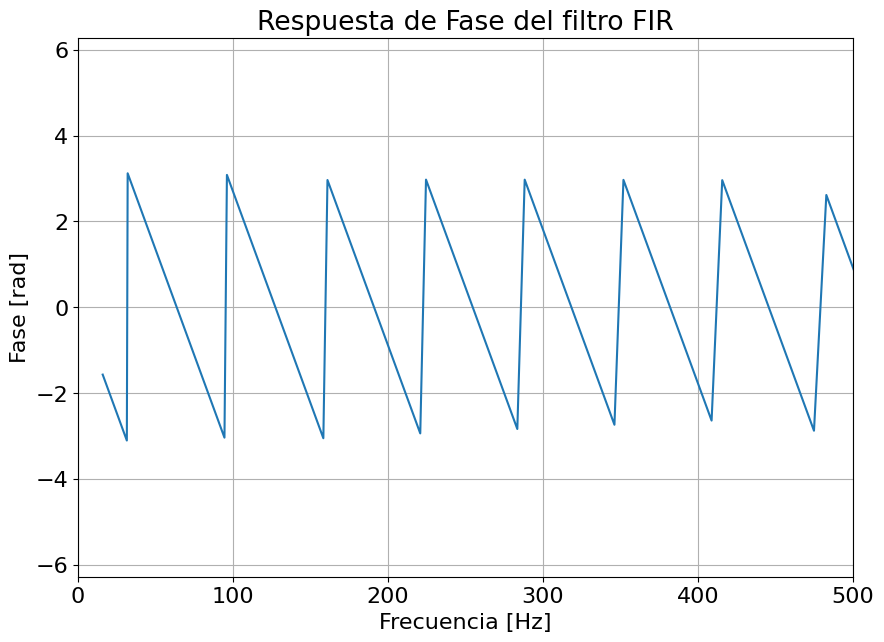

In [28]:
phase=np.angle(hh_win1)
plt.plot((w / np.pi * nyq_frec), phase)

plt.title('Respuesta de Fase del filtro FIR')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Fase [rad]')
plt.grid()
plt.axis([0, nyq_frec, -2*np.pi, 2*np.pi ])

(0.0, 500.0, 0.0, 5000.0)

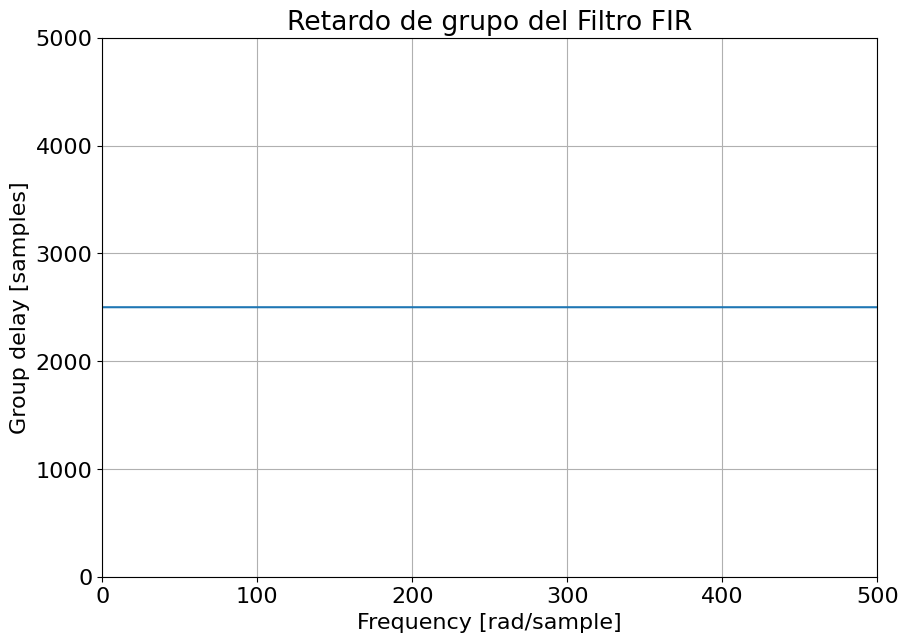

In [29]:
w, gd = sig.group_delay((num_win1, den), w=2000, whole=False, fs=fs)

plt.title('Retardo de grupo del Filtro FIR')
plt.plot(w, gd)
plt.ylabel('Group delay [samples]')
plt.xlabel('Frequency [rad/sample]')
plt.grid()
plt.axis([0, nyq_frec, 0, 5000])

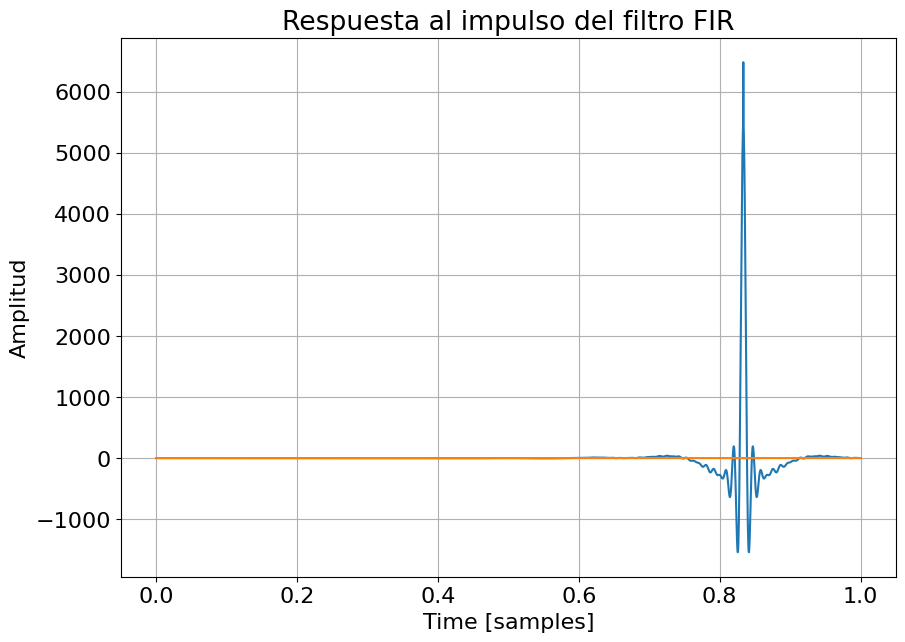

In [30]:
imp = sig.unit_impulse(3000)

den=np.zeros(5001)
den[0]=1

response = sig.lfilter(num_win1, den, imp)

plt.plot(np.linspace(0,1, 3000), response*(10**5))
plt.plot(np.linspace(0,1, 3000), imp)
##plt.ylim([0,10])

plt.xlabel('Time [samples]')
plt.ylabel('Amplitud')
plt.title('Respuesta al impulso del filtro FIR')

plt.grid(True)
plt.show()

## Parte 2 - Aplicación del Filtro FIR diseñado
Una vez diseñados los filtros procedemos a utilizarlos. Para ello SciPy dispone de dos implementaciones de la ecuación de diferencias, la tradicional mediante lfilter y la variante por SOS's mediante sosfilt. La primera puede usarse para filtros FIR de cualquier tamaño, e IIR de bajo orden (<= 3 secciones u orden 6), mientras que la segunda es obligatoria para filtros IIR de orden superior.
Debido a que el filtro IIR posee una retardo de grupo no constante, se descarta su uso como filtro para una señal de ECG, ya que introduciría una distorsión notable.

## Aplicación del Filtro FIR utilizando "lfilter", para contaminación alta de un ECG
En una primera etapa, se evalúa la eficacia del filtro diseñado para eliminar la interferencia notoria en una señal de ECG.

In [31]:
###
## Señal de ECG registrada a 1 kHz, con contaminación de diversos orígenes.
###

# para listar las variables que hay en el archivo
mat_struct = sio.loadmat('ecg.mat')

ecg_one_lead = mat_struct['ecg_lead']
ecg_one_lead = ecg_one_lead.flatten()
cant_muestras = len(ecg_one_lead)

fs = 1000 # Hz
nyq_frec = fs / 2

fig_sz_x = 10
fig_sz_y = 7
fig_dpi = 100 # dpi

fig_font_size = 16

mpl.rcParams['figure.figsize'] = (fig_sz_x,fig_sz_y)
plt.rcParams.update({'font.size':fig_font_size})

In [32]:
# IIR
# ECG_f_butt = sig.sosfilt(bp_sos_butter, ecg_one_lead)

# FIR
ECG_f_win = sig.lfilter(num_win1, den, ecg_one_lead)

Ahora visualizamos los resultados, para ello se cuenta con diferentes regiones de interés (ROI's) para poder evaluar qué tan bien se comportan los filtros diseñados. Primero revisaremos zonas de alta contaminación para evaluar qué tan eficiente es el filtrado.

Recordar que cada filtro impone una demora a la señal filtrada, por lo tanto, dicha demora puede corregirse para cada filtro retrasando la señal de entrada o adelantando la señal de salida. Recuerde que como la señal ya fue registrada, una secuencia puede adelantarse.

In [33]:
#Se calcula el retardo del filtro para sincronizar la señal de entrada y salida

w, gd = sig.group_delay((num_win1, den), w=2000, whole=False, fs=fs)
demora=int(np.round(gd[250]))

print("Demora =",demora)

Demora = 2500


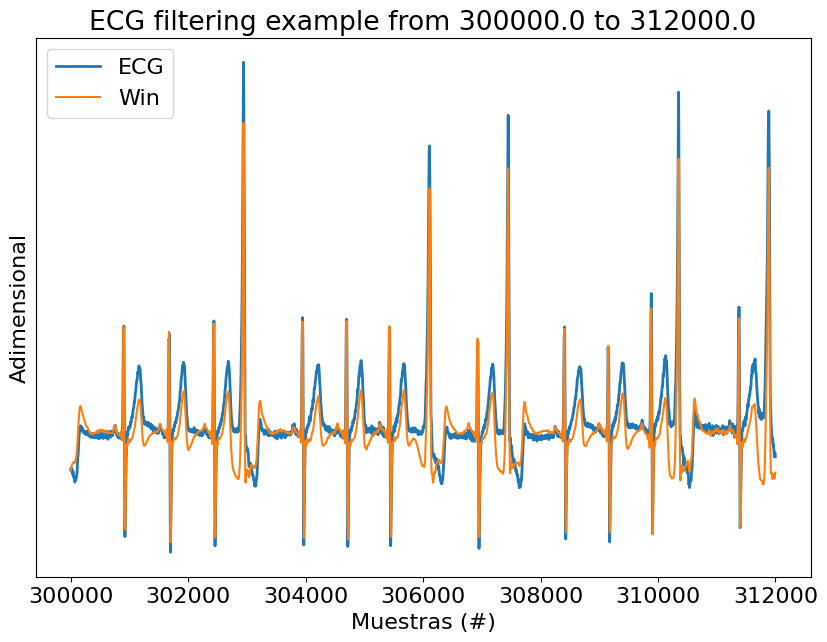

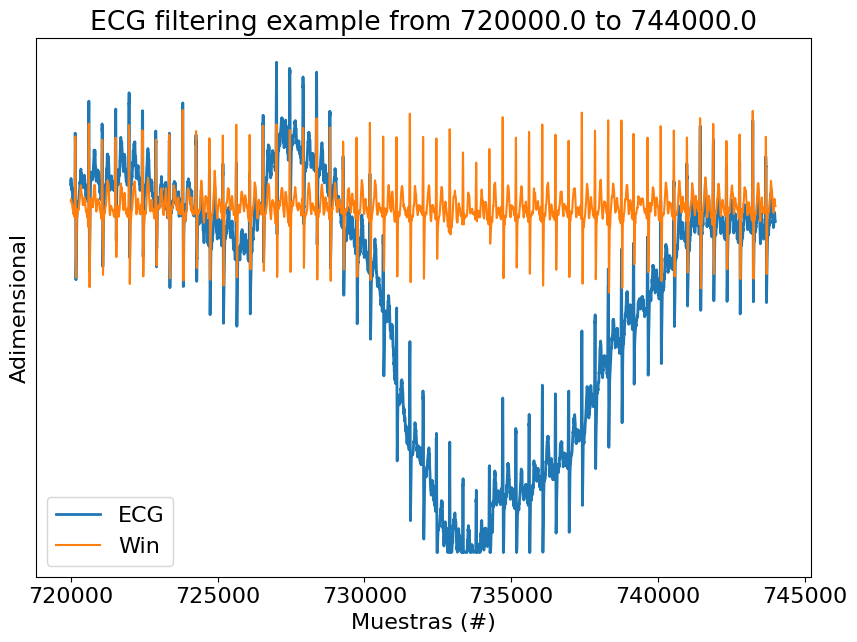

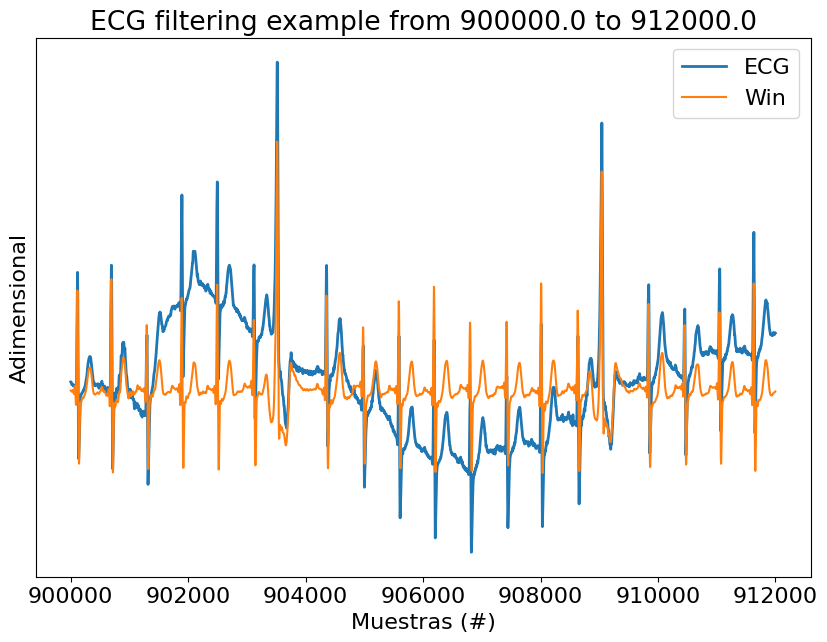

In [34]:
# Segmentos de interés con ALTA contaminación

regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

## Conclusiones de la aplicación del Filtro FIR para filtrar una señal de ECG altamente contaminada

Es evidente que la señal original del ECG (representada en azul) está afectada por una señal sinusoidal de baja frecuencia. Después de aplicar el filtro diseñado, esta distorsión ha sido exitosamente eliminada.

## Aplicación del Filtro FIR para un ECG sin contaminación
Ahora analizaremos cómo se han comportado los filtros analizando la señal en detalle para algunos latidos con baja contaminación, es decir qué tan inocuo es el filtro en su banda de paso. Desde luego nos interesará que la señal de ECG no haya sido alterada en su morfología, debido a que esto podría imposibilitar su uso como método de diagnóstico.

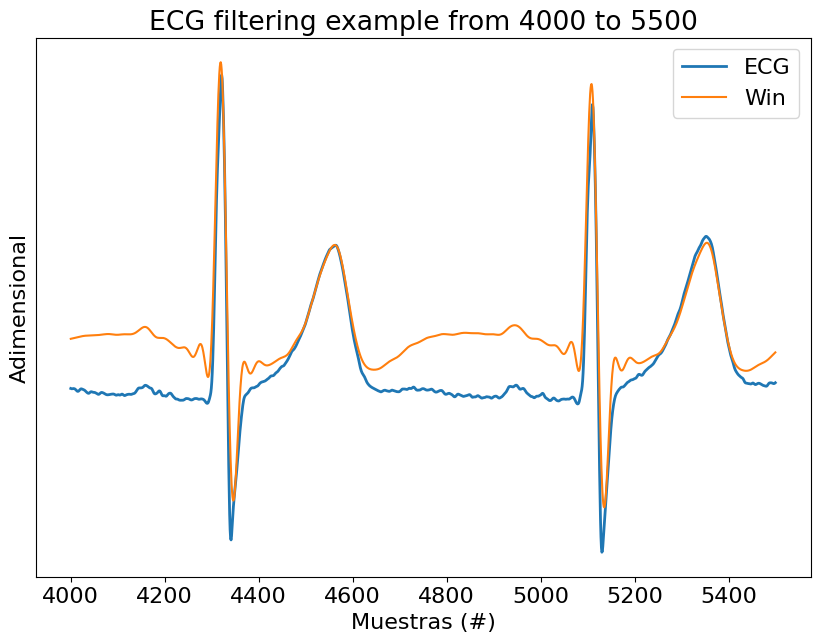

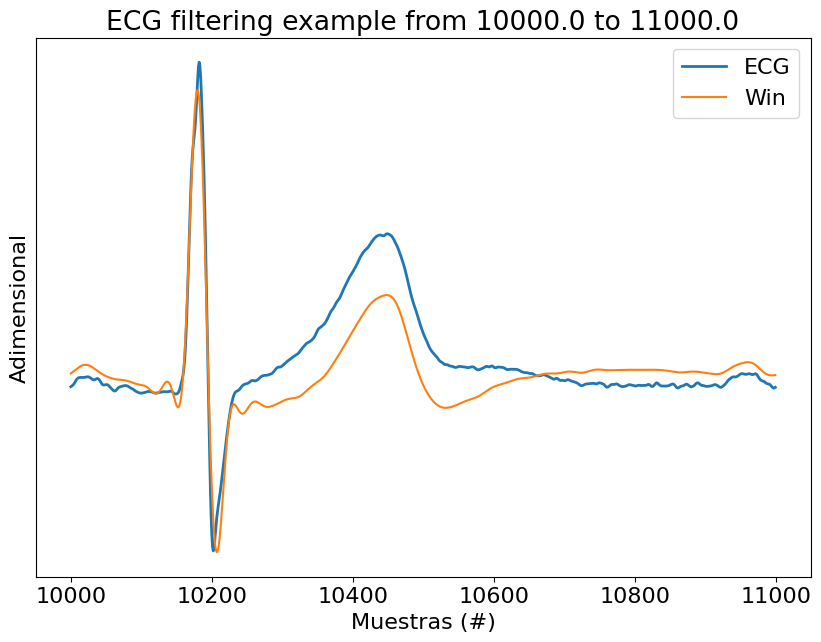

In [35]:
regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())

## Conclusiones de la aplicación del Filtro FIR para filtrar una señal de ECG sin contaminar
Al analizar tanto la señal del ECG original (representada en azul) como la señal filtrada (en naranja), se hace evidente que el filtro introduce una distorsión significativa en la señal. Este resultado indica que la señal filtrada no puede ser considerada como un método de diagnóstico válido y, por lo tanto, el filtro diseñado no cumple con su propósito.
Debido a que el retardo de grupo del filtro FIR es constante, se descarta como el causante de la distorsión.

# Parte 3 - Preguntas
* **¿Qué pudo haber causado que los filtros no hayan sido eficientes para eliminar las interferencias?**
    A raíz de lo expuesto en el presente informe, se concluye que el filtro es efectivo para eliminar las interferencias de señales de baja frecuencia.    

* **¿Qué pudo haber causado que los filtros no hayan sido inocuos respecto a las señales NO contaminadas?** 
    Es posible que el filtro esté eliminando frecuencias de interés clave, es decir, que la plantilla inicial esté mal planteada.
